# Import and Define

Project 3: Multi-Modal Deep Learning Model for Fake News Detection

Authors Jason Phillips and Peeja

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tf-explain
!pip install --upgrade gensim
#!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Import and print out the current version of packages.
%load_ext tensorboard

import tensorflow as tf
import tf_explain
import numpy as np
import matplotlib.pyplot as plt
import sys
import sklearn as sk
import pandas as pd
import shutil
import os
import imblearn
import io
import requests
import datetime

from scipy.stats import zscore
from scipy import spatial

from collections.abc import Sequence
from collections import Counter
from numpy import where
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,LSTM
from keras.activations import relu, sigmoid, tanh
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from gensim.models import Word2Vec
from gensim import corpora
from gensim.utils import simple_preprocess
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

print('Python {}'.format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print('Tensor Flow {}'.format(tf.__version__))
print('Keras {}'.format(tf.keras.__version__))
print('Imblearn {}'.format(imblearn.__version__))

#Remove any files in the log folder for tensorboard
!rm -rf "/content/drive/MyDrive/Colab Notebooks/logs/"

Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Pandas 1.4.4
Numpy 1.22.4
Scikit-Learn 1.2.2

Tensor Flow 2.11.0
Keras 2.11.0
Imblearn 0.10.1


In [4]:
#Define the log folder for tensorboard
log_dir = "/content/drive/MyDrive/Colab Notebooks/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Data Preprocessing

Import dataset and preprocess it.

In [ ]:
"""import string
from pprint import pprint

max_sentence_len = 200

with open("/content/drive/MyDrive/Colab Notebooks/data/devset/tweets.txt", encoding = 'utf-8') as file_:
    docs = file_.readlines()
    
sentences = [[word for word in doc.lower().translate(str.maketrans('','',string.punctuation)).split()[:max_sentence_len]] for doc in docs]
print('Num sentences:', len(sentences))
"""

Num sentences: 14484


In [ ]:
"""
del sentences[0]
"""

In [ ]:
#tweets_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/devset/tweet_features.csv', na_values = ['NA', '?'])
#tweets_df

In [ ]:
"""
i = 0
tweets = []
imageID = []
dropped_rows = []
for i in range(len(sentences)):
  if(sentences[i][-1] != "humor"):
    tweets.append(sentences[i][1:-10])
    imageID.append(sentences[i][0:-8])
  #else:
    #tweets_df = tweets_df.drop([i])
    """

'\ni = 0\ntweets = []\nimageID = []\ndropped_rows = []\nfor i in range(len(sentences)):\n  if(sentences[i][-1] != "humor"):\n    tweets.append(sentences[i][1:-10])\n    imageID.append(sentences[i][0:-8])\n  #else:\n    #tweets_df = tweets_df.drop([i])\n    '

In [ ]:
"""
for i in range(len(imageID)):
  if('sandyafake' not in imageID[i]):
    print("Tweet ID: ", imageID[i][0])
    print(imageID[i][-1])
#tweets
"""

In [ ]:
#tweets_df

In [ ]:
"""
print('Num sentences:', len(sentences))
print('Num of sentence without humor:', len(tweets))
#sentences[0][1:-11]
"""

Num sentences: 14483
Num of sentence without humor: 11850


In [ ]:
#https://www.youtube.com/watch?v=ZrgVlfNduj8

#New Processing Text Tweets


In [5]:
filename_read = open("/content/drive/MyDrive/Colab Notebooks/data/devset/tweets.txt", "r")

In [6]:
df = pd.read_csv(filename_read, sep='\t', header=0)
df

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake
...,...,...,...,...,...,...,...
14272,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,Tue Mar 11 03: 48: 36 +0000 2014,fake
14273,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,Mon Mar 10 18: 09: 26 +0000 2014,fake
14274,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,Mon Mar 10 10: 59: 45 +0000 2014,fake
14275,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,Sun Mar 09 20: 07: 10 +0000 2014,fake


In [7]:
df.to_csv("tweet_dataframe.csv", index=False)

In [8]:
df.shape

(14277, 7)

In [9]:
df = df.drop_duplicates(subset=["tweetText"])

In [10]:
df.shape

(12376, 7)

In [11]:
df = df[df["label"] != "humor"]

In [12]:
df.shape

(9986, 7)

In [13]:
df = df[df["imageId(s)"] != ""]

In [14]:
df.shape

(9986, 7)

In [15]:
df[df["imageId(s)"] == "passport_01"] 

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
13204,476036494574895104,Just a reminder to all toddler dads. Don't lea...,137950763,passport_01,toarjunmenonk,Mon Jun 09 16:21:59 +0000 2014,fake
13213,473512620495212544,Oh ... RT @DailyMirror: Dad stranded after hi...,20449115,passport_01,Sweder,Mon Jun 02 17:13:00 +0000 2014,fake


In [16]:
tkr = RegexpTokenizer('[a-zA-Z]+')

In [17]:
df['tokenized'] = df['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])

In [18]:
df['tokenized']

0        [se, acuerdan, de, la, pel, cula, el, d, a, de...
1        [milenagimon, miren, a, sandy, en, ny, tremend...
2        [buena, la, foto, del, hurac, n, sandy, me, re...
3        [scary, shit, hurricane, ny, http, t, co, e, j...
4        [my, fave, place, in, the, world, nyc, hurrica...
                               ...                        
14272    [bobombdom, slaps, tweetdeck, with, the, pigfi...
14273    [new, species, of, fish, found, in, brazil, or...
14274    [what, do, we, call, this, pigfish, http, t, c...
14275    [pigfish, e, dopo, il, pescecane, c, il, pesce...
14276    [for, those, who, can, t, decide, between, fis...
Name: tokenized, Length: 9986, dtype: object

In [19]:
tweets = df['tokenized']
print(tweets[0])

['se', 'acuerdan', 'de', 'la', 'pel', 'cula', 'el', 'd', 'a', 'despu', 's', 'de', 'ma', 'ana', 'me', 'recuerda', 'a', 'lo', 'que', 'est', 'pasando', 'con', 'el', 'hurac', 'n', 'sandy', 'http', 't', 'co', 'jqqerpwn']


#Word2Vec

Training our model

In [20]:
print('\nTraining word2vec...')
word_model = Word2Vec(tweets, vector_size=300, min_count=5, sg=1, window=5, epochs=100)

pretrained_weights = word_model.wv.vectors

vocab_size, emdedding_size = pretrained_weights.shape


Training word2vec...


In [21]:
word_model.save('word2vec_model_scratch')

In [22]:
word_model = Word2Vec.load('word2vec_model_scratch')

In [29]:
word_model.wv.similar_by_word('boston')

[('suspect', 0.6586228609085083),
 ('bombing', 0.6106695532798767),
 ('marathon', 0.5303793549537659),
 ('bombings', 0.48264873027801514),
 ('bomber', 0.4716378152370453),
 ('zoom', 0.46676182746887207),
 ('suspects', 0.4617871642112732),
 ('fbi', 0.4606752097606659),
 ('releases', 0.4578503966331482),
 ('chan', 0.4196198284626007)]

In [54]:
word_model.wv.most_similar(positive=['sandy', 'boston'])

[('suspect', 0.4638027846813202),
 ('bombing', 0.4583887755870819),
 ('marathon', 0.40353822708129883),
 ('releases', 0.3772198557853699),
 ('zoom', 0.36627405881881714),
 ('fbi', 0.36627405881881714),
 ('bomber', 0.35868823528289795),
 ('colando', 0.3574151396751404),
 ('bombings', 0.3557000160217285),
 ('multitud', 0.34238043427467346)]

In [69]:
from sklearn.manifold import TSNE


def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, perplexity= 10, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

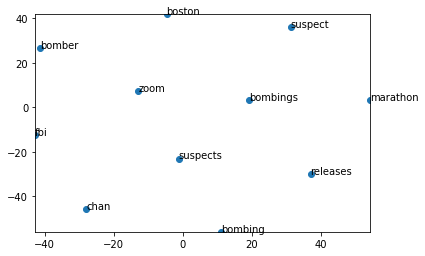

In [71]:
display_closestwords_tsnescatterplot(word_model,'boston')   

# Word2Vec Transfer Learning

Training google's model

In [72]:
from gensim.models import KeyedVectors
filename = "/content/drive/MyDrive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz"
model2 = KeyedVectors.load_word2vec_format(filename, binary=True)

In [73]:
model2.most_similar(positive=['boston'], topn=10)

[('baltimore', 0.6731643676757812),
 ('denver', 0.6526027917861938),
 ('nyc', 0.6515336036682129),
 ('cleveland', 0.6461560726165771),
 ('oakland', 0.6356480717658997),
 ('seattle', 0.621021568775177),
 ('chicago', 0.6184597015380859),
 ('detroit', 0.6172025799751282),
 ('minneapolis', 0.6117672324180603),
 ('toronto', 0.6114994883537292)]

In [74]:
model2.most_similar(negative=['boston'], topn=10)

[('Robert_Arsiaga', 0.245956689119339),
 ('McCl_NPR', 0.2343364953994751),
 ('Seven_Per_Cent', 0.229800745844841),
 ('Organization_WHO', 0.22772109508514404),
 ('Horticultural_Exporters', 0.22644758224487305),
 ('Cardio_thoracic_Surgery', 0.22616052627563477),
 ('Jaris_Judd_sophomore', 0.22385360300540924),
 ('TISHOMINGO_Okla.', 0.2233773022890091),
 ('Company_NROCC', 0.22328844666481018),
 ('Wholesale_Grocers', 0.22281822562217712)]

In [78]:
# size option needs to be set to 300 to be the same as Google's pre-trained model 
word2vec_model = Word2Vec(vector_size=300, min_count=5, sg=1, window=5, epochs=300)


word2vec_model.build_vocab(tweets)

word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))


# assign the vectors to the vocabs that are in Google's pre-trained model and your sentences defined above.
# lockf needs to be set to 1.0 to allow continued training.
word2vec_model.wv.intersect_word2vec_format('/content/drive/MyDrive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

In [79]:
word2vec_model.train(tweets,  # our COVID dataset 
                     total_examples=9986,          #might have to change this     
                     epochs = 5)

(430549, 813060)

In [80]:
word2vec_model.save('word2vec_model_transfer')

In [81]:
word2vec_model = Word2Vec.load('word2vec_model_transfer')

In [82]:
word2vec_model.wv.most_similar(positive=['boston'], topn=20)

[('suspect', 0.6917253732681274),
 ('bostonstrong', 0.6477212905883789),
 ('dzhokhar', 0.6256217360496521),
 ('tsarnaev', 0.596376895904541),
 ('bostonbombingsuspects', 0.5708255767822266),
 ('tripathi', 0.5534188151359558),
 ('bombing', 0.5494701862335205),
 ('imgur', 0.5178351998329163),
 ('cambridge', 0.49082547426223755),
 ('hat', 0.46314048767089844),
 ('released', 0.4419916868209839),
 ('him', 0.40622538328170776),
 ('qh', 0.4049012362957001),
 ('possible', 0.3972354829311371),
 ('second', 0.391330748796463),
 ('thematthewkeys', 0.37422168254852295),
 ('nhttps', 0.3443443477153778),
 ('cleveland', 0.3440653383731842),
 ('find', 0.3438003957271576),
 ('conrad', 0.3413343131542206)]

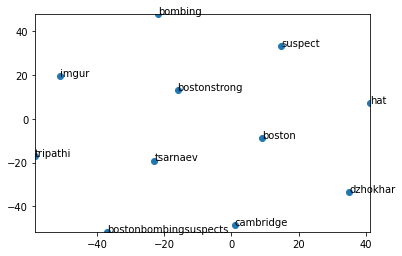

In [83]:
display_closestwords_tsnescatterplot(word2vec_model,'boston')

In [84]:
word2vec_model.wv['boston']

array([-0.38611344,  0.17193425,  0.13501859,  0.43291187,  0.23971295,
       -0.51999587,  0.08322938, -0.31527483, -0.0349516 ,  0.05162198,
       -0.3569829 , -0.8218394 , -0.19632505,  0.05201557,  0.13277087,
        0.4942411 , -0.04485956, -0.85927916,  0.706532  , -0.8020581 ,
        0.0017036 ,  0.09588633, -0.10489547, -0.12867492, -0.5967489 ,
       -0.08446386, -0.37996635, -0.15530896, -0.2967248 , -0.04437865,
        0.10944918, -0.02035599,  0.36924112,  0.02131331, -0.20523325,
       -0.11809911,  0.2623334 ,  0.13051128,  0.48203915,  0.15014613,
       -0.0248429 , -0.27393946, -0.02748815, -0.41511688, -0.19585231,
        0.3115041 , -0.10234071, -0.43963376,  0.162898  , -0.00225819,
        0.08523802,  0.0397652 , -0.06221198,  0.17182688, -0.26710922,
       -0.11026844,  0.07681638, -0.44002545,  0.01230098, -0.08663228,
        0.12807448,  0.3864834 , -0.12116855,  0.04080655, -0.0954656 ,
       -0.51786834,  0.12021783, -0.01028731,  0.31021428,  0.49

In [ ]:
word2vec_model.wv[0]

In [96]:
word2vec_model.wv[0].shape

(300,)

#Functional Model

Put everything together:
word2vec_model = Neural Network
Image data = CNN